# Perfect subarray

Find all subarrays of an array that sum to a perfect square (an integer-based square, or k^2 for some k that is integer).

In [1]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt
import time

Here are several solutions, from the most stupid and slow, to the most fast and complex.

**Option 1: Brute-force.** A true brute-forth solution. Considers all sums, calculates the sqrt(), checks if it's an integer. As stupid as it can get.

In [22]:
def solution_bf(nums):
    """Brute-force."""
    n = len(nums)
    out = 0
    for j in range(1,n+1):
        for i in range(j):
            s = sum(nums[i:j])
            if s>=0:
                s = np.sqrt(s)
                if s-int(s)==0:
                    out += 1
    return out

solution_bf([4,0,0,16])

9

**Option 2: Precalculate squares.**: Still brute-force sums, but pre-calculates and hashes squares. The magic number for how many squares to calcualte is based on the rules that all numbers are <100, but one could use other adaptive approaches here (like, extending the set on demand for example...)

In [10]:
def solution_bf1(nums):
    """Brute-force with pre-calculated and hashed squares."""
    squares = set([i**2 for i in range(int(np.sqrt(len(nums)*100))+1)])
    n = len(nums)
    out = 0
    for j in range(1,n+1):
        for i in range(j):
            if sum(nums[i:j]) in squares:
                out += 1
    return out

solution_bf1([4,0,0,16])

9

**Option 3: Use sliding window for sums.** Instead of calculating all possible sums from scratch (which means an $O(n^3)$ complexity), calculate sums using a sliding window, and just subtracting items from one end, and adding them at another (should move us to $O(n^2)$ complexity). Squares are still pre-calculated.

In [9]:
def solution_bfo(nums):
    """Optimization of summing (sliding windows to get from O(n3) to O(n2)."""
    squares = set([i**2 for i in range(int(np.sqrt(len(nums)*100))+1)])  # Pre-calc and hash squares
    out = 0
    n = len(nums)
    first_sum = 0                           # to avoid re-running sum(nums[:m])
    for m in range(1,n+1):
        for i in range(n-m+1):
            if i==0:
                s = first_sum + nums[i+m-1]
                first_sum = s
            else:
                s += nums[i+m-1]-nums[i-1]
            if s in squares:
                out += 1
    return out

solution_bfo([4,0,0,16])

9

**Option 4: Hash-table for previous observed sums.** This is a standard solution for problems like "For a given array, find all pairs of numbers that sum to a given number". The idea here is to shave one more degree from $O(n^p)$ by storing in a hash table all "suitable" values that can "complete" a given sum to the target. It is totally counter-intuitive (or at least it was for me), but the trick is that checking whether an element is in a hash table is almost instantaneous, while going through all possible pairs takes time. Same here: instead of considering all possible sums, let's look at previously observed sums, and check whether we can use the current sums and some of the previously observed sums to cook a full square.

Here's how it works in practice. A sum of elements from $L$ to $R$ is a sum of elements from $0$ to $R$ minus the sum of elements from $0$ to $L$ (in the notation where the left border is included in the sum, but the right border doesn't). Which means that instead of checking all possible subarrays $LR$ that finish at $R$, we can consider one large subarray $0R$ that goes from $0$ to $R$, and then carefully compare this sum with all sums that go from $0$ to all possible $L$, $L<R$. If $0L$ sum is what makes $0R$ sum miss a perfect square $Q$, let's just drop the $0L$, and the remaining $LR$ sum will qualify.

But as we don't actually want to loop through all $0L$ sums, but want to look up in a hash table "a value that would work", it means that we kinda need to know the square ($Q$). Then we can just check whether $0R-Q$ is in the hash table of all previously observed $0L$ sums, for $L<R$.

But that means that we need to loop through all possible perfect squares $Q$. Which is totally counterinuitive, as in the previous solution we have just pre-calculated them, in order not to calculate them every time, and now we are perfectly willing to loop through them for every element $R$ in the array. But that's the trade-off. We need to cycle through something, so that we could look up the last missing piece up in the table. And in this case cycling through squares is cheaper. (Especially if we give up early on, and don't go to ridiculously high values of $k^2$, the moment we realize that they are unachievable with current values of $R$. Which we can do, if bounds on the number of elements in the array, and the value of these elements, are given).

In [14]:
def solution_hash(nums):
    squares = [i**2 for i in range(int(np.sqrt(len(nums)*100))+1)]
    out = 0
    n = len(nums)
    hm = {}
    s = 0                   # Current sum
    smallest_ever = 0       # Smallest partial sum ever observed, to guess the top limit on subarray sum.
    for i in range(n):      # For each element
        s += nums[i]        # Calculate current sum
        for sq in squares:  # Go through all squares
            if sq>s-smallest_ever: # If there's no hope to exceed this square..
                break              # ...halt these attempts.
            if sq==s:              # If this sum works as is, be happy
                out += 1
            if s-sq in hm:         # If any former sum, if excluded, can bring us to a square
                out += hm[s-sq]    # ..count how many former sums fit the bill.
        if s < smallest_ever:      # If current sum is unusually small (negative numbers),
            smallest_ever = s      # ..remember it.
        hm[s] = hm.get(s, 0)+1     # Remember that current sum was achieved.
    return out

solution_hash([4,0,0,16])

9

**Option 5: Same as above, but with an array for previously observed sums instead of a hash-table.** The benefit that it is faster. The draw-back is that if negative elements are allowed (and they are allowed), then indexing based on the sum $0L$ is a bit tricky, as it can be negative, so we first need to figure out to transform all negative numbers into positives by correctly offsetting them.

In [18]:
def solution_arr(nums):
    squares = [i**2 for i in range(int(np.sqrt(len(nums)*100))+1)]
    out = 0
    t = len(nums)
    mn = mx = 0             # Minimal and maximal sums of 0L arrays 
    s = 0                   # running sum
    for i in range(t):
        s += nums[i]
        if s<mn: mn = s
        if s>mx: mx = s
            
    hm = [0]*(mx-mn+1)      # Former hashmap, but now just an indexed array
    s = 0                   # Current sum
    for i in range(t):      # For each element
        s += nums[i]        # Calculate current sum
        for sq in squares:  # Go through all squares
            if sq>s-mn:     # If there's no hope to exceed this square..
                break              # ...halt these attempts.
            if sq==s:              # If this sum works as is, be happy
                out += 1
            out += hm[s-sq-mn]     # mn is negative, so subtracting it makes index positive
        hm[s-mn] += 1       # Remember that current sum was achieved.
    return out

solution_arr([4,0,0,16])

9

In [12]:
def make_input(n=10):
    return np.random.choice(range(-100,100), n)
    
a = make_input(100)
print(' '.join([str(i) for i in a]))

34 2 34 -51 75 23 -16 -84 -42 16 57 -6 99 42 -88 3 -88 -99 -39 43 86 -56 -16 -72 -51 -60 -62 11 78 68 59 -1 25 -49 17 -46 -11 -39 -67 50 35 -21 43 37 -12 84 -58 18 93 47 29 11 93 23 -81 42 57 79 -41 35 -55 25 -2 10 -23 -68 13 -65 67 -61 1 84 -40 43 -56 71 -100 -63 0 -70 3 36 31 33 23 65 18 -24 0 -75 25 80 -16 -32 -44 -38 -30 -58 -42 29


In [50]:
# Some randomized testing of different solutions (just a sanity check)
for i in range(1000):
    l = i % 100
    a = make_input(l)
    answer1 = solution_bfo(a)
    answer2 = solution_arr(a)
    if answer1 != answer2:
        print(a)
    # With random inputs, both methods seem to produce identical answers...

In [19]:
a = make_input(1000)
print('Brute-force:')
%time solution_bf(a)
print('Brute-force with hashing squares:')
%time solution_bf1(a)
print('Smart summing + hashing squares:')
%time solution_bfo(a)
print('Dynamic programming solution:')
%time solution_hash(a)
print('Dynamic programming, and no hashmap:')
%time solution_arr(a)

Brute-force:
1000
Wall time: 23.3 s
Brute-force with hashing squares:
Wall time: 23.9 s
Smart summing + hashing squares:
Wall time: 337 ms
Dynamic programming solution:
Wall time: 19 ms
Dynamic programming, and no hashmap:
Wall time: 32.9 ms


5807

In [81]:
a = make_input(1000)

In [23]:
funs = [solution_bf, solution_bf1, solution_bfo, solution_hash, solution_arr]
labels = ['Brute-Force', 'pre-caled squares', 'windowed sum', 'hash-table', 'array']
ns = [5, 10, 20, 50, 100, 200, 300, 400, 500]
total_n = 1000

results = np.zeros((len(ns), len(funs)))
for i_n in range(len(ns)):
    n = ns[i_n]
    ntrials = total_n // n
    print(n, ntrials)
    for itrial in range(ntrials):
        a = make_input(n)
        for i_f in range(len(funs)):
            tic = time.time()
            _ = funs[i_f](a)
            results[i_n, i_f] += time.time()-tic
    results[i_n, :] /= ntrials

5 200
10 100
20 50
50 20
100 10
200 5
300 3
400 2
500 2


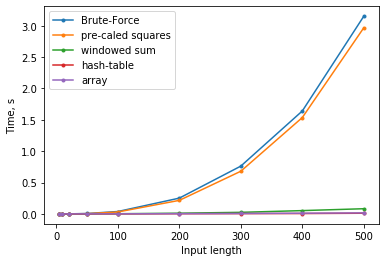

In [25]:
plt.plot(ns, results, '.-',);
plt.legend(labels=labels);
plt.xlabel('Input length');
plt.ylabel('Time, s');

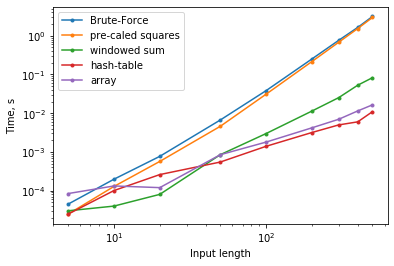

In [26]:
plt.plot(ns, results, '.-',);
plt.xscale('log')
plt.yscale('log')
plt.legend(labels=labels);
plt.xlabel('Input length');
plt.ylabel('Time, s');

## Original submissions

In [8]:
def read_text():
    f = open("input3.txt","r",encoding='utf-8');
    mytext = f.readlines()
    return mytext

def input():
    return mytext.pop(0)

    Case #1: 1
    Case #2: 3
    Case #3: 9

In [10]:
def make_input(n=10):
    return np.random.choice(range(100), n)
    
print(' '.join([str(i) for i in make_input(20)]))

50 33 50 45 27 56 40 76 31 83 8 70 31 36 26 86 47 54 69 30


In [11]:
np.sqrt(1000*100)

316.22776601683796

In [5]:
mytext = read_text() # The only line not to be copied

def option1():
    """Find all subarrays that sum to a perfect square (k^2 where k is integer)"""
    n_cases = int(input())                      # IO interface
    squares = set([i**2 for i in range(3163)])  # Pre-calc and hash squares
    for i_case in range(n_cases):
        out = 0
        t = int(input())                        # IO interface: Array length
        nums = [int(s) for s in input().strip().split(' ')] # IO interface

        first_sum = 0                           # to avoid re-running sum(nums[:m])
        for m in range(1,t+1):
            for i in range(t-m+1):
                if i==0:
                    s = first_sum + nums[i+m-1]
                    first_sum = s
                else:
                    s += nums[i+m-1]-nums[i-1]
                if s in squares:
                    out += 1
        print('Case #'+str(i_case+1)+': ' + str(out))
        
%time option1()

Case #1: 1
Case #2: 3
Case #3: 9
Case #4: 2929
Wall time: 151 ms


Attempt #2, inspired by this: https://www.geeksforgeeks.org/find-subarray-with-given-sum-in-array-of-integers/

In [98]:
mytext = read_text() # The only line not to be copied
# --------------------

def option2():
    n_cases = int(input())
    squares = [i**2 for i in range(3163)]
    for i_case in range(n_cases):
        out = 0
        t = int(input())
        nums = [int(s) for s in input().strip().split(' ')]

        #print(nums)
        hm = {}
        s = 0
        smallest_ever = 0
        for i in range(t):      # For each element
            s += nums[i]        # Calculate current sum
            for sq in squares:  # Go through all squares
                if sq>s-smallest_ever: # If there's no hope to exceed this square..
                    break              # ...halt these attempts.
                if sq==s:              # If this sum works as is, be happy
                    out += 1
                if s-sq in hm:         # If any former sum, if excluded, can bring us to a square
                    out += hm[s-sq]    # ..count how many former sums fit the bill.
            if s < smallest_ever:      # If current sum is unusually small (negative numbers),
                smallest_ever = s      # ..remember it.
            hm[s] = hm.get(s, 0)+1     # Remember current sum was achieved.
        print('Case #'+str(i_case+1)+': ' + str(out))
        
%time option2()

Case #1: 1
Case #2: 3
Case #3: 9
Case #4: 2929
Wall time: 25 ms
